# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


In [5]:
(X > 0).astype(float)

array([[1., 0., 1.],
       [0., 1., 1.]])

In [6]:
(X > 0)*X

array([[ 1. , -0. ,  3. ],
       [-0. ,  2. ,  0.1]])

In [7]:
np.maximum(0,X)

array([[1. , 0. , 3. ],
       [0. , 2. , 0.1]])

А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [8]:
fcl = FullyConnectedLayer(3, 4)
print(fcl.W.value.shape)
print(fcl.B.value.shape)
print(fcl.W.grad)
print(fcl.B.grad)
print(X.shape)
output = fcl.forward(X)
print(output)

(3, 4)
(1, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]]
(2, 3)
[[-0.0010728  -0.00229886 -0.00172451  0.00210108]
 [-0.00438112 -0.00172659  0.0027157  -0.00184225]]


In [9]:
output.sum(axis=0)

array([-0.00545392, -0.00402545,  0.0009912 ,  0.00025884])

In [10]:
d_input = fcl.backward(output)
print(fcl.W.grad)
print(fcl.B.grad)
print(d_input)

[[ 0.00330833 -0.00057227 -0.00444021  0.00394333]
 [-0.00661665  0.00114453  0.00888042 -0.00788666]
 [-0.0036565  -0.00706924 -0.00490195  0.00611902]]
[[-0.00545392 -0.00402545  0.0009912   0.00025884]]
[[ 1.92755838e-07  1.17716419e-07  4.75661339e-06]
 [-5.65794934e-06  1.11644161e-05  7.98088854e-06]]


In [11]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [12]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_o
Gradient check passed!
Checking gradient for B_o
Gradient check passed!
Checking gradient for W_h
Gradient check passed!
Checking gradient for B_h
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [13]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_o
Gradient check passed!
Checking gradient for B_o
Gradient check passed!
Checking gradient for W_h
Gradient check passed!
Checking gradient for B_h
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [14]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30])

0.16666666666666666

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [15]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(),                 
                  num_epochs=20,
                  batch_size=50,
                  learning_rate=0.3)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.150915, Train accuracy: 0.251000, val accuracy: 0.263000
Loss: 1.709217, Train accuracy: 0.456444, val accuracy: 0.447000
Loss: 1.452141, Train accuracy: 0.536556, val accuracy: 0.527000
Loss: 1.378644, Train accuracy: 0.606111, val accuracy: 0.584000
Loss: 1.275005, Train accuracy: 0.642889, val accuracy: 0.623000
Loss: 1.050125, Train accuracy: 0.633000, val accuracy: 0.627000
Loss: 0.864316, Train accuracy: 0.676444, val accuracy: 0.654000
Loss: 1.017418, Train accuracy: 0.703000, val accuracy: 0.651000
Loss: 1.229933, Train accuracy: 0.683222, val accuracy: 0.645000
Loss: 0.975124, Train accuracy: 0.725556, val accuracy: 0.684000
Loss: 1.291682, Train accuracy: 0.695444, val accuracy: 0.663000
Loss: 1.092385, Train accuracy: 0.761000, val accuracy: 0.711000
Loss: 1.173439, Train accuracy: 0.758222, val accuracy: 0.705000
Loss: 1.087579, Train accuracy: 0.740778, val accuracy: 0.702000
Loss: 1.443905, Train accuracy: 0.662667, val accuracy: 0.631000
Loss: 1.038759, Train acc

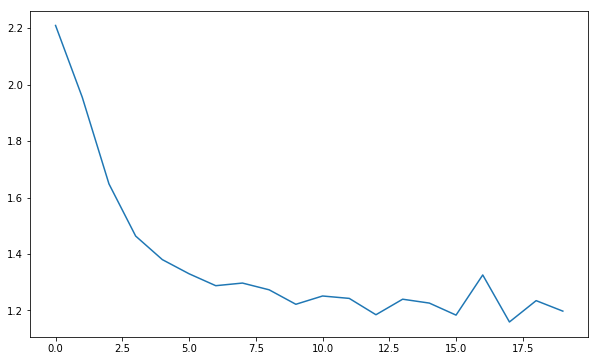

In [16]:
plt.figure(figsize=(10,6))
plt.plot(loss_history)
plt.show()

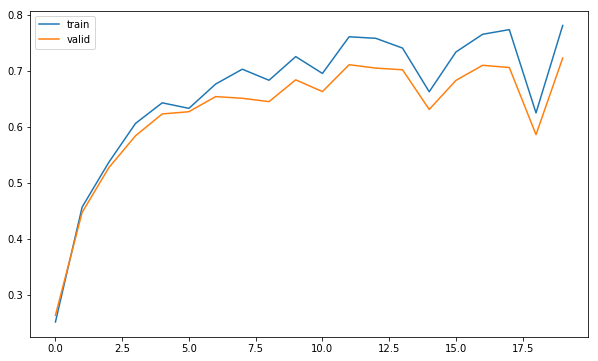

In [17]:
plt.figure(figsize=(10,6))
plt.plot(train_history, label='train')
plt.plot(val_history, label='valid')
plt.legend()
plt.show()

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [15]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(),
                  num_epochs=20,
                  batch_size=50,
                  learning_rate=0.5,             
                  learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.175514, Train accuracy: 0.300556, val accuracy: 0.299000
Loss: 1.961828, Train accuracy: 0.497444, val accuracy: 0.499000
Loss: 1.687991, Train accuracy: 0.454333, val accuracy: 0.453000
Loss: 1.674748, Train accuracy: 0.586111, val accuracy: 0.583000
Loss: 1.586266, Train accuracy: 0.605444, val accuracy: 0.585000
Loss: 1.601435, Train accuracy: 0.672333, val accuracy: 0.655000
Loss: 1.507513, Train accuracy: 0.699556, val accuracy: 0.673000
Loss: 1.532109, Train accuracy: 0.677000, val accuracy: 0.644000
Loss: 1.532722, Train accuracy: 0.634000, val accuracy: 0.627000
Loss: 1.459994, Train accuracy: 0.682667, val accuracy: 0.653000
Loss: 1.479694, Train accuracy: 0.660889, val accuracy: 0.630000
Loss: 1.523692, Train accuracy: 0.712556, val accuracy: 0.676000
Loss: 1.395712, Train accuracy: 0.706556, val accuracy: 0.674000
Loss: 1.584173, Train accuracy: 0.696444, val accuracy: 0.659000
Loss: 1.414146, Train accuracy: 0.597778, val accuracy: 0.557000
Loss: 1.393761, Train acc

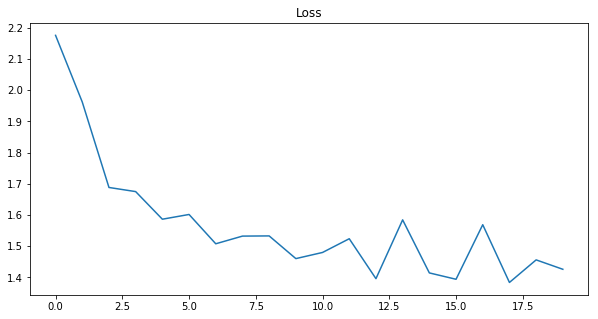

In [16]:
plt.figure(figsize=(10,5))
plt.plot(loss_history)
plt.title('Loss')
plt.show()

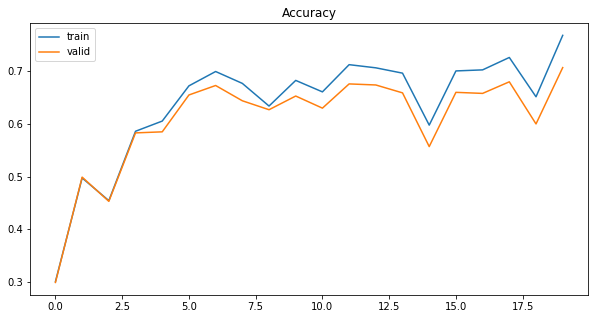

In [17]:
plt.figure(figsize=(10,5))
plt.plot(train_history, label='train')
plt.plot(val_history, label='valid')
plt.title('Accuracy')
plt.legend()
plt.show()

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [34]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-5)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), 
                  num_epochs=20,
                  batch_size=100,
                  learning_rate=1e-1, 
                  learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.215795, Train accuracy: 0.259778, val accuracy: 0.270000
Loss: 1.814480, Train accuracy: 0.438889, val accuracy: 0.448000
Loss: 1.500497, Train accuracy: 0.583444, val accuracy: 0.592000
Loss: 1.212570, Train accuracy: 0.671111, val accuracy: 0.663000
Loss: 1.160443, Train accuracy: 0.658667, val accuracy: 0.619000
Loss: 1.057498, Train accuracy: 0.704667, val accuracy: 0.672000
Loss: 0.996747, Train accuracy: 0.700111, val accuracy: 0.644000
Loss: 0.924891, Train accuracy: 0.696000, val accuracy: 0.628000
Loss: 0.870537, Train accuracy: 0.779222, val accuracy: 0.709000
Loss: 0.826304, Train accuracy: 0.782000, val accuracy: 0.699000
Loss: 0.809250, Train accuracy: 0.780556, val accuracy: 0.705000
Loss: 0.779999, Train accuracy: 0.800333, val accuracy: 0.710000
Loss: 0.732993, Train accuracy: 0.784333, val accuracy: 0.690000
Loss: 0.674367, Train accuracy: 0.826000, val accuracy: 0.716000
Loss: 0.645094, Train accuracy: 0.813778, val accuracy: 0.715000
Loss: 0.612978, Train acc

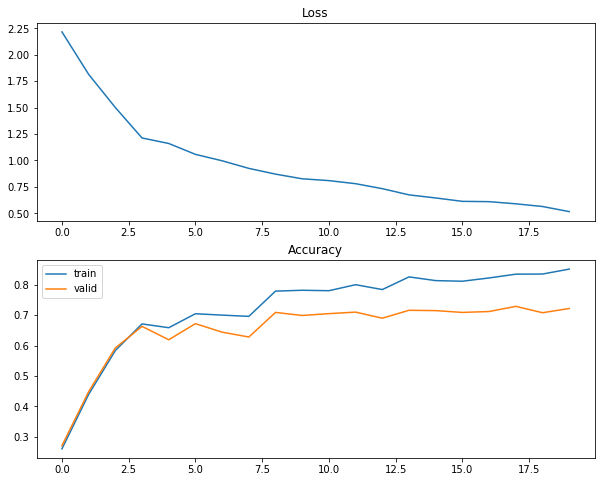

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
ax[0].plot(loss_history)
ax[1].plot(train_history, label='train')
ax[1].plot(val_history, label='valid')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
plt.legend()
plt.show()

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [42]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.333323, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.325340, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.309947, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.297261, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.289399, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.278224, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.269147, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.253734, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.220744, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.170077, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.097331, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.033233, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.951012, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.917145, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.874289, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.892855, Train acc

Loss: 1.278184, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.260578, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.263023, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.288826, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.281909, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.275696, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.260827, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.271397, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.270824, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.266289, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.249203, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.255833, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.250009, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.277981, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.255047, Train accuracy: 1.000000, val accuracy: 0.000000


Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [45]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-5)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=3e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.313372, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.274754, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.250813, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.179876, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 2.104700, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.799439, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.857966, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.647138, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.462960, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.404425, Train accuracy: 0.533333, val accuracy: 0.066667
Loss: 1.401456, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.127004, Train accuracy: 0.533333, val accuracy: 0.066667
Loss: 0.984321, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 0.875162, Train accuracy: 0.666667, val accuracy: 0.066667
Loss: 0.772199, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 0.589244, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **40%** на validation set.

In [9]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-2
reg_strength = 1e-4
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 100
batch_size = 128

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
model = TwoLayerNet(n_input = train_X.shape[1], 
                    n_output = 10,
                    hidden_layer_size=hidden_layer_size,
                    reg=reg_strength)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), 
                  num_epochs=num_epochs,
                  batch_size=batch_size,
                  learning_rate=learning_rates, 
                  learning_rate_decay=learning_rate_decay)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.270915, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.235318, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.230293, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.228190, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.227432, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.227579, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.226535, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.219354, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.196976, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.155300, Train accuracy: 0.228444, val accuracy: 0.240000
Loss: 2.113304, Train accuracy: 0.264556, val accuracy: 0.263000
Loss: 2.078260, Train accuracy: 0.272444, val accuracy: 0.273000
Loss: 2.042505, Train accuracy: 0.273444, val accuracy: 0.275000
Loss: 1.996168, Train accuracy: 0.307444, val accuracy: 0.316000
Loss: 1.927468, Train accuracy: 0.347333, val accuracy: 0.343000
Loss: 1.833449, Train acc

In [10]:
# weghit initializing with *sqrt(2/n_input)
best_classifier = model
best_val_accuracy = multiclass_accuracy(val_y, model.predict(val_X))
print('best validation accuracy achieved: %f' % best_val_accuracy)

best validation accuracy achieved: 0.757000


In [57]:
best_classifier = model
best_val_accuracy = multiclass_accuracy(val_y, model.predict(val_X))
print('best validation accuracy achieved: %f' % best_val_accuracy)

best validation accuracy achieved: 0.766000


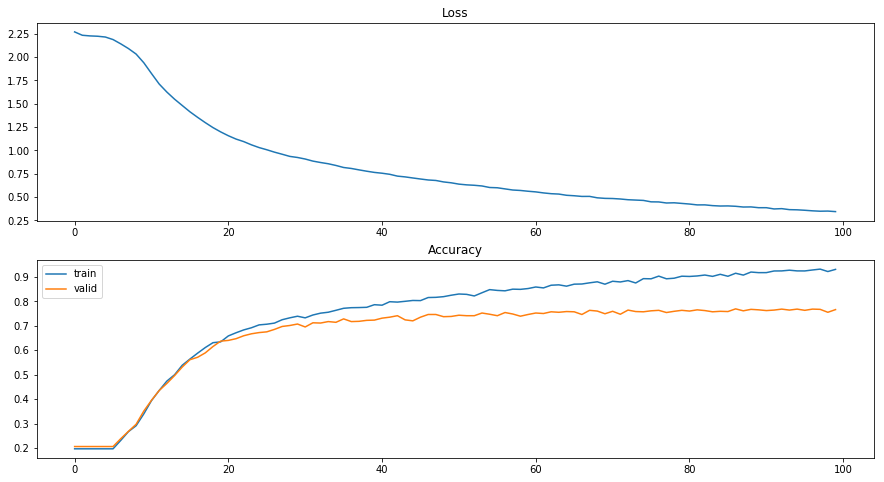

In [58]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,8))
ax[0].plot(loss_history)
ax[1].plot(train_history, label='train')
ax[1].plot(val_history, label='valid')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
plt.legend()
plt.show()

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [59]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.738000
